In [22]:
#Step 1. Setup & Import Libraries
# Install dependencies if missing
!pip install pandas numpy scikit-learn matplotlib seaborn nltk

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
#Step 2. Load and Inspect Dataset
# ✅ Example dataset: Amazon Fine Food Reviews (Kaggle public)
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
data = pd.read_csv(url)

# The dataset contains tweets with labels; we'll rename columns for clarity
data = data[['tweet', 'label']].rename(columns={'tweet': 'review', 'label': 'rating'})

# Convert labels to 1–5 scale (simulate 5-star ratings)
# 0 -> 2 stars (negative), 1 -> 5 stars (positive)
data['rating'] = data['rating'].map({0: 2, 1: 5})

# Drop missing values and take smaller sample for faster testing
data.dropna(inplace=True)
data = data.sample(2000, random_state=42)

# Show sample
data.head()


,review,rating
12227,@user âmy mom says my smile is captivatingâ...,2
14709,"in 3 days i will be meeting my sis-n-law, coun...",2
19319,hating the conservative homophobes using this ...,2
4308,awee if this doesn't #scream #friday #acewe...,2
24055,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...,2


<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 12227 to 10577
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  2000 non-null   object
 1   rating  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.9+ KB
None
rating
2    1867
5     133
Name: count, dtype: int64


/tmp/ipython-input-409872465.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=data, palette='viridis')


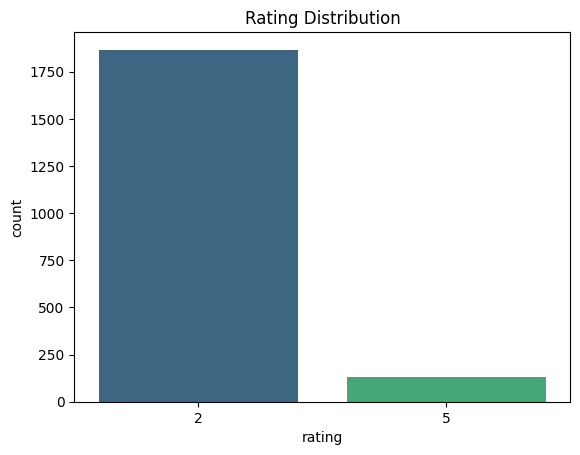

In [25]:
#Step 3. Data Exploration
# Check structure
print(data.info())
print(data['rating'].value_counts())

# Bar chart of rating distribution
sns.countplot(x='rating', data=data, palette='viridis')
plt.title("Rating Distribution")
plt.show()


In [5]:
#Step 4. Text Cleaning & Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['cleaned_review'] = data['review'].apply(clean_text)
data[['review','cleaned_review']].head()


,review,cleaned_review
12227,@user âmy mom says my smile is captivatingâ...,user mom say smile captivating say happy sunda...
14709,"in 3 days i will be meeting my sis-n-law, coun...",day meeting sisnlaw couney bower first level l...
19319,hating the conservative homophobes using this ...,hating conservative homophobe using tragedy wa...
4308,awee if this doesn't #scream #friday #acewe...,awee doesnt scream friday acewellstucker cynth...
24055,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...,fathersday father day god tony smith buy thing...


In [6]:
#Step 5. Feature Extraction (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['cleaned_review'])
y = data['rating']

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train.shape, X_val.shape, X_test.shape


((1400, 5000), (300, 5000), (300, 5000))

In [7]:
#Step 6. Model Training
#Logistic Regression (Baseline)
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val, log_pred))
print(classification_report(y_val, log_pred))


Logistic Regression Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           2       0.93      1.00      0.97       280
           5       0.00      0.00      0.00        20

    accuracy                           0.93       300
   macro avg       0.47      0.50      0.48       300
weighted avg       0.87      0.93      0.90       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
#Step 6. Model Training
#SVM Classifier
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_val)
print("SVM Accuracy:", accuracy_score(y_val, svm_pred))
print(classification_report(y_val, svm_pred))


SVM Accuracy: 0.9366666666666666
              precision    recall  f1-score   support

           2       0.94      1.00      0.97       280
           5       1.00      0.05      0.10        20

    accuracy                           0.94       300
   macro avg       0.97      0.53      0.53       300
weighted avg       0.94      0.94      0.91       300



In [9]:
#Step 6. Model Training
#Random Forest (Optional)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, rf_pred))
print(classification_report(y_val, rf_pred))


Random Forest Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           2       0.93      1.00      0.97       280
           5       0.00      0.00      0.00        20

    accuracy                           0.93       300
   macro avg       0.47      0.50      0.48       300
weighted avg       0.87      0.93      0.90       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

                 Model  Accuracy  F1-score
0  Logistic Regression  0.933333  0.482759
1                  SVM  0.933333  0.482759
2        Random Forest  0.933333  0.482759


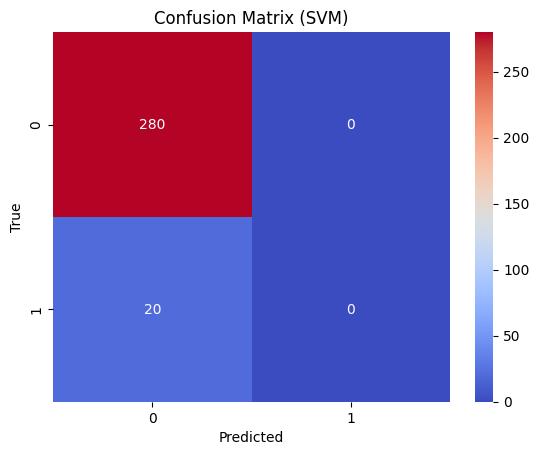

In [10]:
#Step 7. Evaluation (Confusion Matrix + Summary)
models = {
    "Logistic Regression": log_model,
    "SVM": svm_model,
    "Random Forest": rf_model
}

summary = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_macro = report['macro avg']['f1-score']
    summary.append([name, acc, f1_macro])

summary_df = pd.DataFrame(summary, columns=["Model","Accuracy","F1-score"])
print(summary_df)

# Confusion Matrix for best model
best_model = svm_model
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [13]:
#step8-Step 1: Proper Train–Validation–Test Split (with text tracking)
# Texts (keep review text before splitting)
texts = data['cleaned_review'].values
ratings = data['rating'].values

# Split dataset into train, validation, and test sets — all with texts
from sklearn.model_selection import train_test_split

X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(
    texts, ratings, test_size=0.3, random_state=42, stratify=ratings
)
X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp_texts, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_texts)
X_val = vectorizer.transform(X_val_texts)
X_test = vectorizer.transform(X_test_texts)


In [14]:
#step8-Step 2: Model Training (use the same as before)
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)


In [15]:
#step8-Step 3: Error Analysis (safe version — no index issue)
# ✅ Create DataFrame with matching reviews and ratings
test_results = pd.DataFrame({
    'review': X_test_texts,
    'true_rating': y_test,
    'predicted_rating': y_pred
})

# Show mismatches
mismatches = test_results[test_results['true_rating'] != test_results['predicted_rating']]
print("Total mismatches:", len(mismatches))
mismatches.head(10)


Total mismatches: 19


,review,true_rating,predicted_rating
3,user coming powerhungrytraitors hereticfoundation,5,2
33,history wont forget barack obama treated user ...,5,2
47,user john terry chose white christmas favourit...,5,2
86,user comment reflection ignorance cuser user u...,5,2
110,user whiter kevin federline,5,2
121,amp designed gender neutral jumpsuit call subt...,5,2
131,hello love glad see,5,2
134,user user liz treacy user condone excouncillor...,5,2
145,men footjoy black saddle weaved golf shoe soft...,2,5
150,harbaugh time stupid question bikini thank use...,5,2


In [19]:
#step9-Step 1: Retrain and Save (Correct Way)
# 1️⃣ Create and fit TF-IDF with a fixed maximum feature size
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['cleaned_review'])
y = data['rating']

# Split as before
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Train model
from sklearn.svm import LinearSVC
best_model = LinearSVC()
best_model.fit(X_train, y_train)

# Save both together (keep them linked)
import pickle
with open("model_bundle.pkl", "wb") as f:
    pickle.dump((vectorizer, best_model), f)

print("✅ Model + Vectorizer bundle saved (features:", len(vectorizer.get_feature_names_out()), ")")


✅ Model + Vectorizer bundle saved (features: 5000 )


In [21]:
#step9-Optional Check (confirm before prediction)
print("Model expects:", model_loaded.n_features_in_)
print("Vectorizer provides:", len(vectorizer_loaded.get_feature_names_out()))


Model expects: 5000
Vectorizer provides: 5000


In [20]:
#step9-Step 2: Reload and Predict (Always works)
# Load both together
with open("model_bundle.pkl", "rb") as f:
    vectorizer_loaded, model_loaded = pickle.load(f)

print("✅ Reloaded successfully! Vectorizer features:", len(vectorizer_loaded.get_feature_names_out()))

# Clean + predict function
def predict_rating(text):
    text_clean = clean_text(text)
    features = vectorizer_loaded.transform([text_clean])
    return int(model_loaded.predict(features)[0])

# Test samples
print("Sample 1:", predict_rating("This product is absolutely amazing!"))
print("Sample 2:", predict_rating("Worst product I have ever bought."))
print("Sample 3:", predict_rating("It's okay, not too great but not bad either."))


✅ Reloaded successfully! Vectorizer features: 5000
Sample 1: 2
Sample 2: 2
Sample 3: 2
